## Depression Severity Classification using DASS and Demographical Data

This notebook looks at modelling the severity of depression based on the scores given to the DAS assessment and certain demographical indicators.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
df = pd.read_csv("data/dass_data/data.csv", delimiter="\t")
print("Dataset Size:", df.shape)
df.head()

Dataset Size: (39775, 172)


,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
0,4,28,3890,4,25,2122,2,16,1944,4,...,1,1,1,12,1,10,2,1,2,NaN
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,2,7,0,70,2,1,4,NaN
2,3,7,5784,1,33,4373,4,41,3242,1,...,2,1,1,4,3,60,1,1,3,NaN
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,2,4,5,70,2,1,5,biology
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,2,3,10,1,10,2,1,4,Psychology


### Filter Out Columns and Check for Missing Values

This section creates the filters for the relevant columns, i.e for demography data and for the questions related to depression. The entire dataframe is then scanned to check for missing values. As seen below, the dataframe is relatively clean where most missing values only exist in the major column and requires analysis and preprocessing.

In [3]:
df_columns = df.columns

# http://www2.psy.unsw.edu.au/dass/Download%20files/Dass_template.pdf
# The question numbers are taken from the actual Dass template answering sheet.
# These questions specifically relate to depression and the scores given to these questions can classify the severity of depression.
depression_question_numbers = [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]
demography_columns = ["education", "urban", "gender", "engnat", "age", "hand", "religion", "orientation", "race", "voted", "married", "familysize", "major"]
depression_question_columns = [f"Q{i}A" for i in depression_question_numbers]

for column in df_columns:
    nan_count = df[column].isna().sum()
    if nan_count != 0:
        print(f"{column} has {nan_count} missing values")

country has 2 missing values
major has 11403 missing values


### Handling Missing and Inconsistent Values

The NaN values are replaced with the string "None" and treated as category 0.

In [4]:
df["country"] = df["country"].fillna("None")
df["major"] = df["major"].fillna("None")

unique_major_values = df["major"].unique()
print(len(unique_major_values))

5309


### Exploration on Data Demographics

In [20]:
df[demography_columns].describe()

,education,urban,gender,engnat,age,hand,religion,orientation,race,voted,married,familysize
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.00000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,2.503834,2.220264,1.789541,1.635852,23.612168,1.13516,7.555852,1.642992,31.312885,1.705795,1.159547,3.510270
std,0.885414,0.804761,0.444180,0.483906,21.581722,0.40030,3.554395,1.351362,25.871272,0.473388,0.445882,2.141518
min,0.000000,0.000000,0.000000,0.000000,13.000000,0.00000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,1.000000,18.000000,1.00000,4.000000,1.000000,10.000000,1.000000,1.000000,2.000000
50%,3.000000,2.000000,2.000000,2.000000,21.000000,1.00000,10.000000,1.000000,10.000000,2.000000,1.000000,3.000000
75%,3.000000,3.000000,2.000000,2.000000,25.000000,1.00000,10.000000,2.000000,60.000000,2.000000,1.000000,4.000000
max,4.000000,3.000000,3.000000,2.000000,1998.000000,3.00000,12.000000,5.000000,70.000000,2.000000,3.000000,133.000000


An initial view of the summary of the demography columns show that most of the columns correctly follow the stated classes provided, especially since most of them are categorical variables. However, the age columns raises an issue as the maximum age of 1998 does not seem to make sense.

In [24]:
df[df["age"] > 100]["age"]

# df["age"].hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
# plt.grid(False)
# plt.show()

# print(df[df["age"] == 1998])

5340      223
10231    1996
14236     117
21383    1998
24898     115
30027    1993
33730    1991
Name: age, dtype: int64

In [28]:
# Search for dass depression severity scale and go to images
def depression_severity(score):

    if score <= 9:
        severity = "Normal"
    elif score >= 10 and score <= 13:
        severity = "Mild"
    elif score >= 14 and score <= 20:
        severity = "Moderate" 
    elif score >= 21 and score <= 27:
        severity = "Severe" 
    elif score >= 28:
        severity = "Extremely Severe"
    
    return severity

# Select the relevant columns from the original dataframe.
depression_df = df[demography_columns + depression_question_columns].copy()

# The data in the dataset usees a scale from 1 to 4 while the original dass score uses a scale of 0 to 3
# Hence, the scores for each question is subtracted by 1
depression_df[depression_question_columns] = depression_df[depression_question_columns].subtract(1)
depression_df["total_score"] = depression_df[depression_question_columns].sum(axis=1)

depression_df["severity"] = depression_df["total_score"].apply(lambda x: depression_severity(x))
depression_df.head()

,education,urban,gender,engnat,age,hand,religion,orientation,race,voted,...,Q21A,Q24A,Q26A,Q31A,Q34A,Q37A,Q38A,Q42A,total_score,severity
0,2,3,2,2,16,1,12,1,10,2,...,0,3,3,3,2,0,1,3,27,Severe
1,2,3,2,1,16,2,7,0,70,2,...,1,1,2,1,1,3,1,1,24,Severe
2,2,3,2,2,17,1,4,3,60,1,...,3,3,0,3,3,3,3,3,39,Extremely Severe
3,1,3,2,1,13,2,4,5,70,2,...,0,0,1,2,3,1,0,1,16,Moderate
4,3,2,2,2,19,3,10,1,10,2,...,2,1,3,2,3,2,2,2,32,Extremely Severe


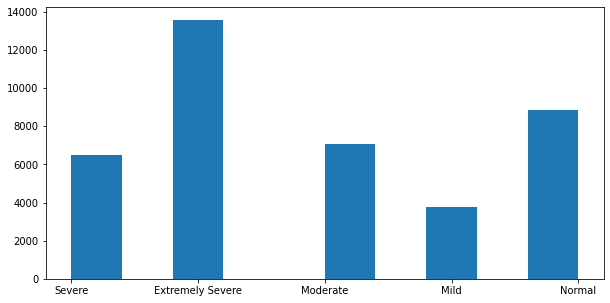

In [7]:
plt.figure(figsize=(10,5))
depression_df["severity"].hist()
plt.grid(False)
plt.show()

In [8]:
def convert_labels(label):
    classes = ["Normal", "Mild", "Moderate", "Severe", "Extremely Severe"]

    return classes.index(label)

label_encoded = depression_df["severity"].apply(lambda x: convert_labels(x))

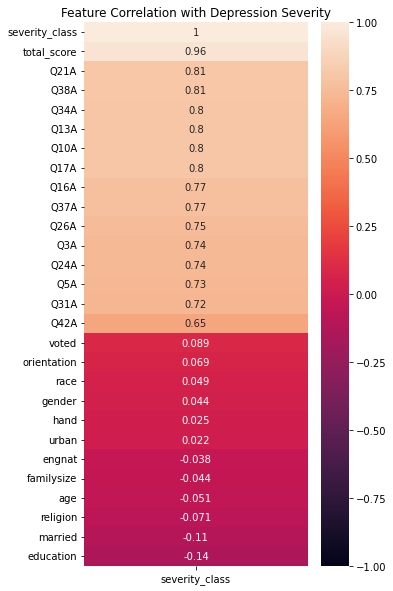

In [9]:
depression_df["severity_class"] = label_encoded

plt.figure(figsize=(5,10))
heatmap = sns.heatmap(depression_df.corr()[["severity_class"]].sort_values(by="severity_class", ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Feature Correlation with Depression Severity")

plt.show()

The heatmap shows that there exists high correlation between the scores of the individual questions and the severity of depression. This tallies with the fact that in the original DAS assessment, the severity is dependent on the sum of these scores and therefore, higher scores per question results in more severe conditions. However, when modelling, total score would not be used as a feature as this could result in redundancy with the original scores.

The demographical features, although showing lower correlation, still have potential to model the severity of depression.

In [10]:
np.random.seed(7)

X = depression_df.drop(["severity", "major", "total_score", "severity_class"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, label_encoded, train_size=0.6)
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(23865, 26)
(15910, 26)


In [12]:
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

c:\Users\Naim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [13]:
y_pred = clf.predict(X_test_scaled)
accuracy = np.mean(y_test == y_pred)
print(accuracy)

0.9992457573852923


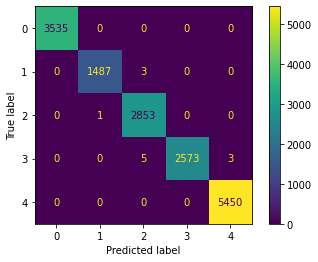

In [14]:
plot_confusion_matrix(clf, X_test_scaled, y_test)
plt.show()